In [308]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import to_date, last_day, year
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


#1.1 Import the data and create the anchor date columns
In order to create features, you need to create some anchor dates. The most typical for transaction data is the end of the month and the year.

In [309]:
# txn = spark.read.csv("dbfs:/FileStore/tables/Retail_Data_Transactions.csv", header=True, inferSchema=True)
# # Task 1: Import the dataset as txn and identify the number of rows
# print("Number of rows in txn:", txn.count())

# # Convert Spark DataFrame to Pandas DataFrame for more complex operations
# txn_pd = txn.toPandas()
# txn_pd.head()

In [310]:
txn_pd = pd.read_csv("Retail_Data_Transactions.csv")

In [311]:
# Task 2: Create a new column 'txn date' from 'trans date' with pd.to_datetime and drop 'trans date'
txn_pd['txn_date'] = pd.to_datetime(txn_pd['trans_date'], errors='coerce')
txn_pd.drop(columns=['trans_date'], inplace=True)



In [312]:
# Task 3: Identify the min() and max() of column 'txn date'
print("Min of txn date:", txn_pd['txn_date'].min())
print("Max of txn date:", txn_pd['txn_date'].max())

Min of txn date: 2011-05-16 00:00:00
Max of txn date: 2015-03-16 00:00:00


In [313]:
# Task 4: Create the column 'ME DT': the last day of the month in the 'trans date' column
txn_pd['ME_DT'] = txn_pd['txn_date'].apply(lambda x: x + pd.offsets.MonthEnd(0))

In [314]:
# Task 5: Create the column 'YEAR': the year in the 'trans date' column
txn_pd['YEAR'] = txn_pd['txn_date'].dt.year

In [315]:
txn_pd.iloc[55]

customer_id                 CS2662
tran_amount                     88
txn_date       2014-08-31 00:00:00
ME_DT          2014-08-31 00:00:00
YEAR                          2014
Name: 55, dtype: object

In [316]:
txn_pd

,customer_id,tran_amount,txn_date,ME_DT,YEAR
0,CS5295,35,2013-02-11,2013-02-28,2013
1,CS4768,39,2015-03-15,2015-03-31,2015
2,CS2122,52,2013-02-26,2013-02-28,2013
3,CS1217,99,2011-11-16,2011-11-30,2011
4,CS1850,78,2013-11-20,2013-11-30,2013
...,...,...,...,...,...
124995,CS8433,64,2011-06-26,2011-06-30,2011
124996,CS7232,38,2014-08-19,2014-08-31,2014
124997,CS8731,42,2014-11-28,2014-11-30,2014
124998,CS8133,13,2013-12-14,2013-12-31,2013


In [317]:
# # Convert the Pandas DataFrame back to Spark DataFrame if needed for further operations in Spark
# txn_final = spark.createDataFrame(txn_pd)

# # Show the result
# txn_final.show()

#1.2 Create features that capture annual spending
Here the approach is to capture the client’s annual spending. The rationale behind this approach is that the clients spend is not very frequent to capture in a monthly aggregation.

In [318]:
#1
clnt_annual_aggregations = txn_pd.groupby(['customer_id', 'YEAR']).agg(
    ann_txn_amt_sum=pd.NamedAgg(column='tran_amount', aggfunc='sum'),
    ann_txn_amt_mean=pd.NamedAgg(column='tran_amount', aggfunc='mean'),
    ann_txn_amt_std=pd.NamedAgg(column='tran_amount', aggfunc='std'),
    ann_txn_amt_var=pd.NamedAgg(column='tran_amount', aggfunc='var'),
    ann_txn_amt_sem=pd.NamedAgg(column='tran_amount', aggfunc='sem'),
    ann_txn_amt_max=pd.NamedAgg(column='tran_amount', aggfunc='max'),
    ann_txn_amt_min=pd.NamedAgg(column='tran_amount', aggfunc='min'),
    ann_txn_cnt=pd.NamedAgg(column='tran_amount', aggfunc='count')
)

clnt_annual_aggregations

ann_txn_amt_sum  ann_txn_amt_mean  ann_txn_amt_std  \
customer_id YEAR                                                       
CS1112      2011              212         70.666667        22.030282   
            2012              337         67.400000        12.720063   
            2013              212         70.666667        34.501208   
            2014              212         70.666667        16.862186   
            2015               39         39.000000              NaN   
...                           ...               ...              ...   
CS9000      2011               39         19.500000         4.949747   
            2012              216         54.000000        16.772994   
            2013              147         73.500000         3.535534   
            2014               97         24.250000         8.261356   
            2015               34         34.000000              NaN   

                  ann_txn_amt_var  ann_txn_amt_sem  ann_txn_amt_max  \
customer_id YEAR                                                      
CS1112      2011       485.333333        12.719189               96   
            2012       161.800000         5.688585               81   
            2013      1190.333333        19.919282              105   
            2014       284.333333         9.735388               90   
            2015              NaN              NaN               39   
...                           ...              ...              ...   
CS9000      2011        24.500000         3.500000               23   
            2012       281.333333         8.386497               77   
            2013        12.500000         2.500000               76   
            2014        68.250000         4.130678               35   
            2015              NaN              NaN               34   

                  ann_txn_amt_min  ann_txn_cnt  
customer_id YEAR                                
CS1112      2011               56            3  
            2012               52            5  
            2013               36            3  
            2014               59            3  
            2015               39            1  
...                           ...          ...  
CS9000      2011               16            2  
            2012               37            4  
            2013               71            2  
            2014               16            4  
            2015               34            1  

[31140 rows x 8 columns]

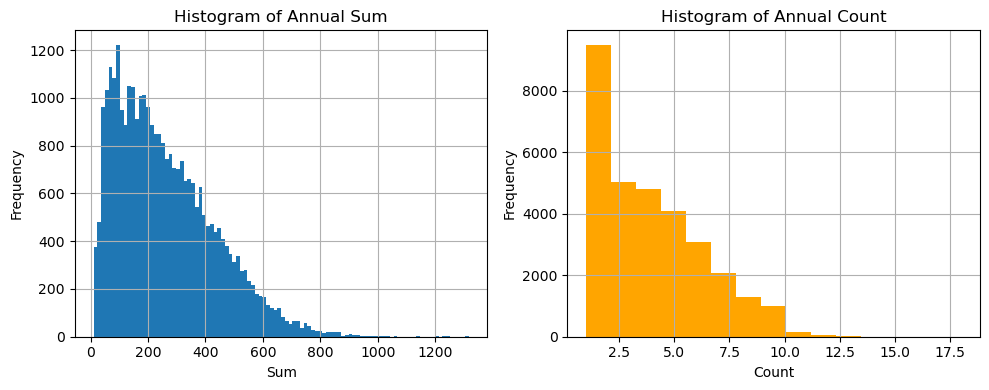

In [319]:
#2 Plot the histogram of the sum and count.
# Plot histogram of the sum

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
clnt_annual_aggregations['ann_txn_amt_sum'].hist(bins=100)
plt.title('Histogram of Annual Sum')
plt.xlabel('Sum')
plt.ylabel('Frequency')

# Plot histogram of the count
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
clnt_annual_aggregations['ann_txn_cnt'].hist(bins=15, color='orange')
plt.title('Histogram of Annual Count')
plt.xlabel('Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [320]:
#3
clnt_annual_aggregations_reset = clnt_annual_aggregations.reset_index()
clnt_annual_aggregations_pivot =  clnt_annual_aggregations_reset.pivot_table(
    index=['customer_id'],
    columns = ['YEAR'],
    values=['ann_txn_amt_sum', 'ann_txn_amt_mean', 'ann_txn_amt_std',
            'ann_txn_amt_var', 'ann_txn_amt_sem', 'ann_txn_amt_max',
            'ann_txn_amt_min', 'ann_txn_cnt'],
    fill_value=0,
    aggfunc=np.sum
)
clnt_annual_aggregations_pivot

ann_txn_amt_max                     ann_txn_amt_mean             \
YEAR                   2011 2012 2013 2014 2015             2011       2012   
customer_id                                                                   
CS1112                   96   81  105   90   39        70.666667  67.400000   
CS1113                   94   95   97   97   98        81.333333  74.800000   
CS1114                   97   97  105   95   79        85.200000  75.000000   
CS1115                  102  104   94   98   55        87.000000  67.571429   
CS1116                   87  105   59   96    0        58.750000  76.666667   
...                     ...  ...  ...  ...  ...              ...        ...   
CS8996                   38   38   50   79    0        31.000000  33.666667   
CS8997                   47   49   75   45    0        45.000000  39.500000   
CS8998                   69   79   75   49    0        64.000000  54.400000   
CS8999                   64   30   39   24    0        52.000000  25.250000   
CS9000                   23   77   76   35   34        19.500000  54.000000   

                                              ... ann_txn_amt_var              \
YEAR              2013       2014       2015  ...            2011        2012   
customer_id                                   ...                               
CS1112       70.666667  70.666667  39.000000  ...      485.333333  161.800000   
CS1113       85.200000  56.500000  73.333333  ...      444.333333  290.200000   
CS1114       70.400000  70.833333  79.000000  ...       94.700000  968.000000   
CS1115       79.571429  78.250000  55.000000  ...      225.000000  477.285714   
CS1116       59.000000  66.600000   0.000000  ...      449.583333  908.333333   
...                ...        ...        ...  ...             ...         ...   
CS8996       41.500000  56.000000   0.000000  ...       98.000000   20.333333   
CS8997       35.166667  42.000000   0.000000  ...        8.000000   45.666667   
CS8998       47.000000  32.500000   0.000000  ...       50.000000  505.300000   
CS8999       28.000000  21.000000   0.000000  ...      333.000000   21.583333   
CS9000       73.500000  24.250000  34.000000  ...       24.500000  281.333333   

                                                 ann_txn_cnt                 \
YEAR                2013        2014        2015        2011 2012 2013 2014   
customer_id                                                                   
CS1112       1190.333333  284.333333    0.000000           3    5    3    3   
CS1113        171.200000  781.666667  745.333333           3    5    5    4   
CS1114        619.300000  726.166667    0.000000           5    2    5    6   
CS1115        110.952381  512.250000    0.000000           3    7    7    4   
CS1116          0.000000  636.800000    0.000000           4    3    1    5   
...                  ...         ...         ...         ...  ...  ...  ...   
CS8996        144.500000  481.600000    0.000000           2    3    2    6   
CS8997        441.366667   18.000000    0.000000           2    4    6    2   
CS8998       1568.000000  219.666667    0.000000           2    5    2    4   
CS8999        103.000000   18.000000    0.000000           3    4    3    2   
CS9000         12.500000   68.250000    0.000000           2    4    2    4   

                  
YEAR        2015  
customer_id       
CS1112         1  
CS1113         3  
CS1114         1  
CS1115         1  
CS1116         0  
...          ...  
CS8996         0  
CS8997         0  
CS8998         0  
CS8999         0  
CS9000         1  

[6889 rows x 40 columns]

In [321]:
#4
clnt_annual_aggregations_reset = clnt_annual_aggregations.reset_index()
clnt_annual_aggregations_pivot =  clnt_annual_aggregations_reset.pivot_table(
    index=['customer_id'],
    columns = ['YEAR'],
    values=['ann_txn_amt_sum', 'ann_txn_amt_mean', 'ann_txn_amt_std',
            'ann_txn_amt_var', 'ann_txn_amt_sem', 'ann_txn_amt_max',
            'ann_txn_amt_min', 'ann_txn_cnt'],
    fill_value=0,
    aggfunc=np.sum
)
clnt_annual_aggregations_pivot

ann_txn_amt_max                     ann_txn_amt_mean             \
YEAR                   2011 2012 2013 2014 2015             2011       2012   
customer_id                                                                   
CS1112                   96   81  105   90   39        70.666667  67.400000   
CS1113                   94   95   97   97   98        81.333333  74.800000   
CS1114                   97   97  105   95   79        85.200000  75.000000   
CS1115                  102  104   94   98   55        87.000000  67.571429   
CS1116                   87  105   59   96    0        58.750000  76.666667   
...                     ...  ...  ...  ...  ...              ...        ...   
CS8996                   38   38   50   79    0        31.000000  33.666667   
CS8997                   47   49   75   45    0        45.000000  39.500000   
CS8998                   69   79   75   49    0        64.000000  54.400000   
CS8999                   64   30   39   24    0        52.000000  25.250000   
CS9000                   23   77   76   35   34        19.500000  54.000000   

                                              ... ann_txn_amt_var              \
YEAR              2013       2014       2015  ...            2011        2012   
customer_id                                   ...                               
CS1112       70.666667  70.666667  39.000000  ...      485.333333  161.800000   
CS1113       85.200000  56.500000  73.333333  ...      444.333333  290.200000   
CS1114       70.400000  70.833333  79.000000  ...       94.700000  968.000000   
CS1115       79.571429  78.250000  55.000000  ...      225.000000  477.285714   
CS1116       59.000000  66.600000   0.000000  ...      449.583333  908.333333   
...                ...        ...        ...  ...             ...         ...   
CS8996       41.500000  56.000000   0.000000  ...       98.000000   20.333333   
CS8997       35.166667  42.000000   0.000000  ...        8.000000   45.666667   
CS8998       47.000000  32.500000   0.000000  ...       50.000000  505.300000   
CS8999       28.000000  21.000000   0.000000  ...      333.000000   21.583333   
CS9000       73.500000  24.250000  34.000000  ...       24.500000  281.333333   

                                                 ann_txn_cnt                 \
YEAR                2013        2014        2015        2011 2012 2013 2014   
customer_id                                                                   
CS1112       1190.333333  284.333333    0.000000           3    5    3    3   
CS1113        171.200000  781.666667  745.333333           3    5    5    4   
CS1114        619.300000  726.166667    0.000000           5    2    5    6   
CS1115        110.952381  512.250000    0.000000           3    7    7    4   
CS1116          0.000000  636.800000    0.000000           4    3    1    5   
...                  ...         ...         ...         ...  ...  ...  ...   
CS8996        144.500000  481.600000    0.000000           2    3    2    6   
CS8997        441.366667   18.000000    0.000000           2    4    6    2   
CS8998       1568.000000  219.666667    0.000000           2    5    2    4   
CS8999        103.000000   18.000000    0.000000           3    4    3    2   
CS9000         12.500000   68.250000    0.000000           2    4    2    4   

                  
YEAR        2015  
customer_id       
CS1112         1  
CS1113         3  
CS1114         1  
CS1115         1  
CS1116         0  
...          ...  
CS8996         0  
CS8997         0  
CS8998         0  
CS8999         0  
CS9000         1  

[6889 rows x 40 columns]

40 columns:
The expectation of 40 columns comes from the combination of multiple years and multiple statistics. The data has 5 years and 8 aggregation functions (sum, mean, std, var, sem, max, min, count). Hence 5 years * 8 functions = 40 columns.


Choice of Imputation Value:
In the pivot table function, fill_value=0 is used to impute NaN entries. This choice is made for two reasons.

First, for financial or count data, a NaN typically indicates the absence of transactions or data for a given period, which can logically be interpreted as 0 for many cases (e.g., no transactions occurred, hence the sum or count would be 0).
Second, using 0 maintains the integrity of sum, count, and other aggregations, ensuring they reflect the actual observed data without introducing bias that might come from imputing with means or other statistics.

In [322]:
print(clnt_annual_aggregations_pivot.columns.nlevels)
print(clnt_annual_aggregations_pivot.columns)


2
MultiIndex([( 'ann_txn_amt_max', 2011),
            ( 'ann_txn_amt_max', 2012),
            ( 'ann_txn_amt_max', 2013),
            ( 'ann_txn_amt_max', 2014),
            ( 'ann_txn_amt_max', 2015),
            ('ann_txn_amt_mean', 2011),
            ('ann_txn_amt_mean', 2012),
            ('ann_txn_amt_mean', 2013),
            ('ann_txn_amt_mean', 2014),
            ('ann_txn_amt_mean', 2015),
            ( 'ann_txn_amt_min', 2011),
            ( 'ann_txn_amt_min', 2012),
            ( 'ann_txn_amt_min', 2013),
            ( 'ann_txn_amt_min', 2014),
            ( 'ann_txn_amt_min', 2015),
            ( 'ann_txn_amt_sem', 2011),
            ( 'ann_txn_amt_sem', 2012),
            ( 'ann_txn_amt_sem', 2013),
            ( 'ann_txn_amt_sem', 2014),
            ( 'ann_txn_amt_sem', 2015),
            ( 'ann_txn_amt_std', 2011),
            ( 'ann_txn_amt_std', 2012),
            ( 'ann_txn_amt_std', 2013),
            ( 'ann_txn_amt_std', 2014),
            ( 'ann_txn_amt_std', 2015)

From the above result, there are 2 levels. As each statistical measure is repeated for each year from 2011 to 2015, and there are 8 different statistics, the total number of columns would be 8 statistics times 5 years, totaling 40 columns. This corresponds to the 40 columns mentioned earlier.

In [323]:
# 5 Flatten the MultiIndex to single level columns
import openpyxl
# !pip install openpyxl
#level_0 captures the first level of the column MultiIndex and converts it to a string. These represent the types of statistical measures, like 'ann_txn_amt_ave', 'ann_txn_amt_max', etc.
level_0 = clnt_annual_aggregations_pivot.columns.get_level_values(0).astype(str)

#level_1 captures the second level of the column MultiIndex and converts it to a string. These represent the years, like 2011, 2012, etc.
level_1 = clnt_annual_aggregations_pivot.columns.get_level_values(1).astype(str)

#combines level_0 and level_1 into a single string for each column name, separated by an underscore _, and then assigns these new column names to the DataFrame. The result is a set of column names like 'ann_txn_amt_ave_2011', 'ann_txn_amt_ave_2012', etc.
clnt_annual_aggregations_pivot.columns = level_0 + '_' + level_1

clnt_annual_aggregations_pivot

# Now save the DataFrame to an Excel file
clnt_annual_aggregations_pivot.to_csv('annual_features.csv', index=False)


6
When capturing client transaction behavior with annual features as described, several possible disadvantages may arise:

Loss of Temporal Details: Annual aggregation loses granular temporal information about transactions. For example, it won't capture seasonality or specific patterns that occur at a finer time scale (monthly, weekly, daily) which could be significant for understanding client behavior.

Outliers May Skew Data: Annual averages and sums can be heavily influenced by outlier transactions. A few very large or very small transactions could distort what the average transaction looks like.

Variability Within Year Ignored: Variance within the year is not captured. For example, a client may have a period of high activity followed by inactivity, but the annual aggregation would only provide a summary without this detail.

Overgeneralization: The aggregation could lead to overgeneralization of client behavior. For instance, if a client's spending habits change significantly from one year to the next, this method would not capture the transition well.

Non-Uniform Impact of Inflation: Monetary values from different years are not directly comparable due to inflation. Unless the amounts are adjusted for inflation, comparisons across years might be misleading.

#1.3 Create monthly aggregations

In [324]:
clnt_monthly_aggregations = txn_pd.groupby(['customer_id', 'ME_DT']).agg(
    mth_txn_amt_sum=pd.NamedAgg(column='tran_amount', aggfunc='sum'),
    mth_txn_cnt=pd.NamedAgg(column='tran_amount', aggfunc='count')
).reset_index()

clnt_monthly_aggregations

,customer_id,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS1112,2011-06-30,56,1
1,CS1112,2011-08-31,96,1
2,CS1112,2011-10-31,60,1
3,CS1112,2012-04-30,56,1
4,CS1112,2012-06-30,52,1
...,...,...,...,...
103229,CS9000,2014-01-31,16,1
103230,CS9000,2014-05-31,20,1
103231,CS9000,2014-07-31,26,1
103232,CS9000,2014-08-31,35,1


In [325]:
# Filter for a specific customer with ID 'CS1112' to match the snapshot provided
cs1112_monthly_aggregations = clnt_monthly_aggregations[clnt_monthly_aggregations['customer_id'] == 'CS1112']
cs1112_monthly_aggregations

,customer_id,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS1112,2011-06-30,56,1
1,CS1112,2011-08-31,96,1
2,CS1112,2011-10-31,60,1
3,CS1112,2012-04-30,56,1
4,CS1112,2012-06-30,52,1
5,CS1112,2012-07-31,81,1
6,CS1112,2012-09-30,72,1
7,CS1112,2012-12-31,76,1
8,CS1112,2013-03-31,105,1
9,CS1112,2013-07-31,36,1


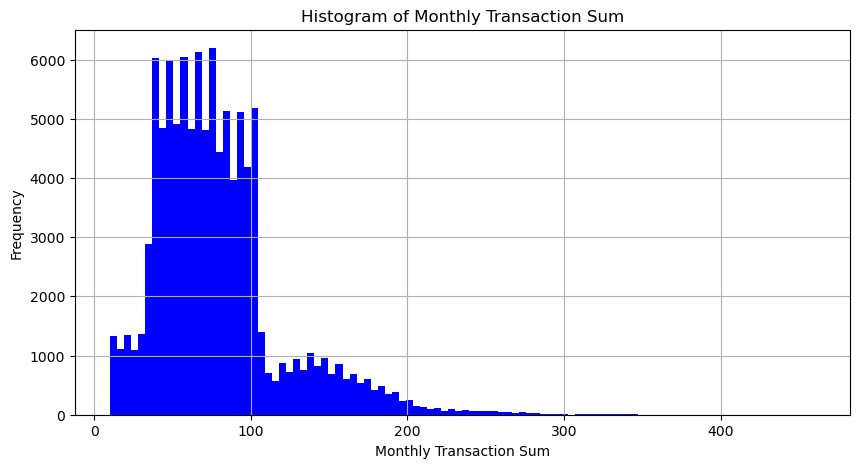

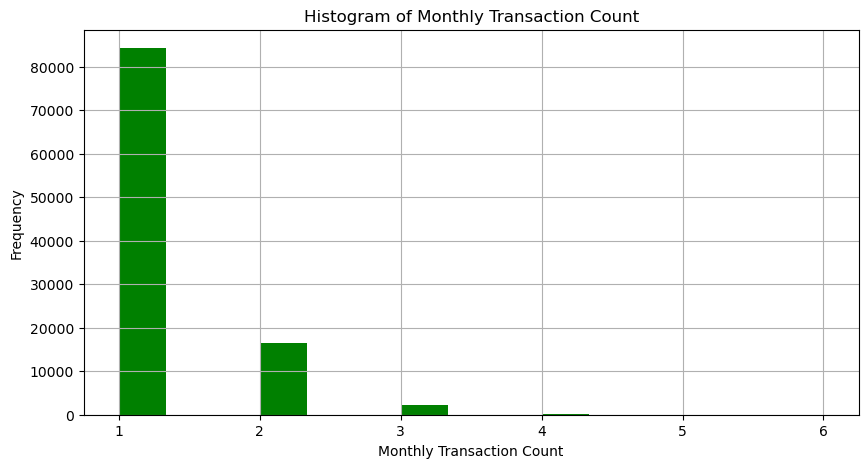

In [326]:
import matplotlib.pyplot as plt

# Assuming 'clnt_monthly_aggregations' has been created as per previous instructions

# Histogram for monthly transaction sum
plt.figure(figsize=(10, 5))
plt.hist(clnt_monthly_aggregations['mth_txn_amt_sum'], bins=100, color='blue')
plt.title('Histogram of Monthly Transaction Sum')
plt.xlabel('Monthly Transaction Sum')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for monthly transaction count
plt.figure(figsize=(10, 5))
plt.hist(clnt_monthly_aggregations['mth_txn_cnt'], bins=15, color='green')
plt.title('Histogram of Monthly Transaction Count')
plt.xlabel('Monthly Transaction Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


1.2 Annual vs. 1.3 Monthly 

Monthly Transaction Histograms: The histograms show the distribution of transaction sums and counts on a monthly basis.

The histogram of the monthly transaction sum appears to be right-skewed, indicating that lower transaction sums occur more frequently than higher sums.
The histogram of the monthly transaction count shows a steep decline after 1, suggesting that most clients tend to have only one transaction per month.

Annual Transaction Histograms: These histograms represent the distribution of transaction sums and counts on an annual basis.

The histogram of the annual sum is also right-skewed, which is typical for transactional data, where there are many small transactions and a few very large transactions.
The histogram of the annual count has a wider spread than the monthly count histogram, suggesting greater variation in the number of transactions clients make annually compared to monthly.

There is a higher frequency of lower sums and counts in both the monthly and annual histograms. This is consistent with the nature of transactional data where many small transactions are more common than a few large ones. 

Also, the spread of transaction sums is broader in the annual histogram than in the monthly histogram, as expected, because the annual sum is the aggregation of all monthly sums.

#1.4 Create the base table for the rolling window features

create a base table with all possible combinations of ’customer id’ and ’ME DT’. For example, customer CS1112 should have 47 entries, one for each month, in which 15 will have the value of transaction amount and the rest 32 will have zero value for transaction amount. This will essentially help you convert the ”irregular” clnt monthly aggregations table into a ”regular” one.

In [327]:
# 1 Creating the numpy array of unique elements in the 'customer_id' and 'ME_DT' columns
unique_customer_ids = np.unique(txn_pd['customer_id'])
unique_ME_DT = np.unique(txn_pd['ME_DT'])  # Convert to period (Month)

print('Unique client number ',len(unique_customer_ids))
print('Unique month-end-date ',len(unique_ME_DT))

Unique client number  6889
Unique month-end-date  47


In [328]:
#2
from itertools import product 
base_table = product(unique_customer_ids, unique_ME_DT)
type(base_table)


itertools.product

In [329]:
#3 Convert the itertools.product object to a pandas DataFrame
base_table_pd = pd.DataFrame.from_records(base_table, columns=['CLNT_NO', 'ME_DT'])
base_table_pd

,CLNT_NO,ME_DT
0,CS1112,2011-05-31
1,CS1112,2011-06-30
2,CS1112,2011-07-31
3,CS1112,2011-08-31
4,CS1112,2011-09-30
...,...,...
323778,CS9000,2014-11-30
323779,CS9000,2014-12-31
323780,CS9000,2015-01-31
323781,CS9000,2015-02-28


In [330]:
#4 Validation 1: Filter client CS1112 and check the date range and number of rows
cs1112_data = base_table_pd[base_table_pd['CLNT_NO'] == 'CS1112']


# Check if dates for CS1112 fall between the min and max month-dates from 1.1
cs1112_date_check = cs1112_data['ME_DT'].between('2011-05-16', '2015-03-31')

print(cs1112_date_check)

cs1112_data


0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
Name: ME_DT, dtype: bool


,CLNT_NO,ME_DT
0,CS1112,2011-05-31
1,CS1112,2011-06-30
2,CS1112,2011-07-31
3,CS1112,2011-08-31
4,CS1112,2011-09-30
5,CS1112,2011-10-31
6,CS1112,2011-11-30
7,CS1112,2011-12-31
8,CS1112,2012-01-31
9,CS1112,2012-02-29


#1.5 Create the monthly rolling window features

With the base table pd as a starting point we can convert the irregular transaction data into the typical time series data; data captured at equal intervals. Feature engineering of time series data gives we the potential to build very powerful predictive models.

In [331]:
#1
clnt_monthly_aggregations = clnt_monthly_aggregations.rename(columns={'customer_id': 'CLNT_NO'})
clnt_monthly_aggregations

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS1112,2011-06-30,56,1
1,CS1112,2011-08-31,96,1
2,CS1112,2011-10-31,60,1
3,CS1112,2012-04-30,56,1
4,CS1112,2012-06-30,52,1
...,...,...,...,...
103229,CS9000,2014-01-31,16,1
103230,CS9000,2014-05-31,20,1
103231,CS9000,2014-07-31,26,1
103232,CS9000,2014-08-31,35,1


In [332]:
base_table_pd

,CLNT_NO,ME_DT
0,CS1112,2011-05-31
1,CS1112,2011-06-30
2,CS1112,2011-07-31
3,CS1112,2011-08-31
4,CS1112,2011-09-30
...,...,...
323778,CS9000,2014-11-30
323779,CS9000,2014-12-31
323780,CS9000,2015-01-31
323781,CS9000,2015-02-28


In [333]:
# Left-join the 'base_table_pd' DataFrame with the 'clnt_monthly_aggregations' DataFrame

# Perform the left join
base_clnt_mth = base_table_pd.merge(clnt_monthly_aggregations, on=['CLNT_NO', 'ME_DT'], how='left')

base_clnt_mth

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS1112,2011-05-31,NaN,NaN
1,CS1112,2011-06-30,56.0,1.0
2,CS1112,2011-07-31,NaN,NaN
3,CS1112,2011-08-31,96.0,1.0
4,CS1112,2011-09-30,NaN,NaN
...,...,...,...,...
323778,CS9000,2014-11-30,NaN,NaN
323779,CS9000,2014-12-31,NaN,NaN
323780,CS9000,2015-01-31,NaN,NaN
323781,CS9000,2015-02-28,34.0,1.0


􏰀 Why do some rows have NaN values?

Rows have NaN values in the base_clnt_mth table because it is the result of a left join between base_table_pd (which contains all possible combinations of clients and month-end dates) and clnt_monthly_aggregations (which contains only months where transactions occurred). If there were no transactions for a given client-month pair in clnt_monthly_aggregations, the joined table will show NaN values for the sum and count of transactions for that client-month.

􏰀 What values will you choose to impute NaN values in the sum and count columns?

For transaction sums (mth_txn_amt_sum), it would be appropriate to impute 0 because no transactions imply a sum of 0.
For transaction counts (mth_txn_cnt), 0 would also be appropriate because no transactions mean a count of 0.


In [334]:
# Impute NaN values for sum and count with 0
base_clnt_mth['mth_txn_amt_sum'].fillna(0, inplace=True)
base_clnt_mth['mth_txn_cnt'].fillna(0, inplace=True)
base_clnt_mth

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS1112,2011-05-31,0.0,0.0
1,CS1112,2011-06-30,56.0,1.0
2,CS1112,2011-07-31,0.0,0.0
3,CS1112,2011-08-31,96.0,1.0
4,CS1112,2011-09-30,0.0,0.0
...,...,...,...,...
323778,CS9000,2014-11-30,0.0,0.0
323779,CS9000,2014-12-31,0.0,0.0
323780,CS9000,2015-01-31,0.0,0.0
323781,CS9000,2015-02-28,34.0,1.0


􏰀 Confirm that the number of rows is what you expect. What is the value?

The number of rows in base_clnt_mth should match base_table_pd, which is 323,783, given that it is a left join of base_table_pd with clnt_monthly_aggregations. The join should not remove or add any rows, just fill in details where they exist.

􏰀 How are tables base_clnt_mth and clnt_monthly_aggregations different? Comment on the number of rows and the content of each table.

base_clnt_mth is a comprehensive table that includes all possible client-month combinations, with imputed values for months with no transactions.
clnt_monthly_aggregations contains actual data for months where transactions took place, without any imputation.
The number of rows in base_clnt_mth (323,783) is greater than in clnt_monthly_aggregations, which would have fewer rows since it only contains data for months with transactions.

In [335]:
# 2 First, sort the data by 'CLNT_NO' and 'ME_DT'
base_clnt_mth_sorted = base_clnt_mth.sort_values(by=['CLNT_NO', 'ME_DT'])
base_clnt_mth_sorted.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS1112,2011-05-31,0.0,0.0
1,CS1112,2011-06-30,56.0,1.0
2,CS1112,2011-07-31,0.0,0.0
3,CS1112,2011-08-31,96.0,1.0
4,CS1112,2011-09-30,0.0,0.0


In [336]:
#3
def rolling_window_features(df, window):
    # df.groupby('CLNT_NO')
    rolling_features = df.rolling(window, min_periods=1).agg(['sum', 'mean', 'max'])
    return rolling_features

grouped = base_clnt_mth_sorted.groupby('CLNT_NO')

# Calculate 3, 6, and 12-month rolling window features
rolling_features_3M = rolling_window_features(grouped[['mth_txn_amt_sum', 'mth_txn_cnt']], 3)
rolling_features_6M = rolling_window_features(grouped[['mth_txn_amt_sum', 'mth_txn_cnt']], 6)
rolling_features_12M = rolling_window_features(grouped[['mth_txn_amt_sum', 'mth_txn_cnt']], 12)

rolling_features_3M

mth_txn_amt_sum                  mth_txn_cnt               
                           sum       mean   max         sum      mean  max
CLNT_NO                                                                   
CS1112  0                  0.0   0.000000   0.0         0.0  0.000000  0.0
        1                 56.0  28.000000  56.0         1.0  0.500000  1.0
        2                 56.0  18.666667  56.0         1.0  0.333333  1.0
        3                152.0  50.666667  96.0         2.0  0.666667  1.0
        4                 96.0  32.000000  96.0         1.0  0.333333  1.0
...                        ...        ...   ...         ...       ...  ...
CS9000  323778             0.0   0.000000   0.0         0.0  0.000000  0.0
        323779             0.0   0.000000   0.0         0.0  0.000000  0.0
        323780             0.0   0.000000   0.0         0.0  0.000000  0.0
        323781            34.0  11.333333  34.0         1.0  0.333333  1.0
        323782            34.0  11.333333  34.0         1.0  0.333333  1.0

[323783 rows x 6 columns]

In [337]:
rolling_features_6M

mth_txn_amt_sum                  mth_txn_cnt               
                           sum       mean   max         sum      mean  max
CLNT_NO                                                                   
CS1112  0                  0.0   0.000000   0.0         0.0  0.000000  0.0
        1                 56.0  28.000000  56.0         1.0  0.500000  1.0
        2                 56.0  18.666667  56.0         1.0  0.333333  1.0
        3                152.0  38.000000  96.0         2.0  0.500000  1.0
        4                152.0  30.400000  96.0         2.0  0.400000  1.0
...                        ...        ...   ...         ...       ...  ...
CS9000  323778            61.0  10.166667  35.0         2.0  0.333333  1.0
        323779            61.0  10.166667  35.0         2.0  0.333333  1.0
        323780            35.0   5.833333  35.0         1.0  0.166667  1.0
        323781            34.0   5.666667  34.0         1.0  0.166667  1.0
        323782            34.0   5.666667  34.0         1.0  0.166667  1.0

[323783 rows x 6 columns]

In [338]:
rolling_features_12M

mth_txn_amt_sum                  mth_txn_cnt               
                           sum       mean   max         sum      mean  max
CLNT_NO                                                                   
CS1112  0                  0.0   0.000000   0.0         0.0  0.000000  0.0
        1                 56.0  28.000000  56.0         1.0  0.500000  1.0
        2                 56.0  18.666667  56.0         1.0  0.333333  1.0
        3                152.0  38.000000  96.0         2.0  0.500000  1.0
        4                152.0  30.400000  96.0         2.0  0.400000  1.0
...                        ...        ...   ...         ...       ...  ...
CS9000  323778            97.0   8.083333  35.0         4.0  0.333333  1.0
        323779            97.0   8.083333  35.0         4.0  0.333333  1.0
        323780            81.0   6.750000  35.0         3.0  0.250000  1.0
        323781           115.0   9.583333  35.0         4.0  0.333333  1.0
        323782           115.0   9.583333  35.0         4.0  0.333333  1.0

[323783 rows x 6 columns]

􏰀 How many rows appear with NaN values at the beginning of each client for 3, 6 and 12-month windows, respectively? Why do they appear?

There should not be any NaN values because we imputed all the NaN values with 0 in the previous step. However, if a row of NaN exists in 3 months window size, then it should also appear in the 6 months and 12 monoths becuase they don't have enough prior data to form a complete window. 

􏰀 How many levels do the index and columns have? Are these MultiIndex dataframes?

The index has a single level, which is CLNT_NO. 

The columns are a MultiIndex, with the first level for the measure (mth_txn_amt_sum, mth_txn_cnt) and the second level for the statistical function (sum, mean, max). 


In [339]:
import pandas as pd

def rename_rolling_features_columns(df, period):
    # Create a dictionary that maps the old MultiIndex column names
    # to the desired format
    col_mapping = {
        ('mth_txn_amt_sum', 'sum'): f'amt_sum_{period}',
        ('mth_txn_amt_sum', 'mean'): f'amt_mean_{period}',
        ('mth_txn_amt_sum', 'max'): f'amt_max_{period}',
        ('mth_txn_cnt', 'sum'): f'txn_cnt_sum_{period}',
        ('mth_txn_cnt', 'mean'): f'txn_cnt_mean_{period}',
        ('mth_txn_cnt', 'max'): f'txn_cnt_max_{period}',
    }
    # Flatten the MultiIndex and apply the new column names
    df.columns = [col_mapping[col] if col in col_mapping else '_'.join(col) for col in df.columns]
    return df
#

rolling_features_3M = rename_rolling_features_columns(rolling_features_3M, '3M')
rolling_features_6M = rename_rolling_features_columns(rolling_features_6M, '6M')
rolling_features_12M = rename_rolling_features_columns(rolling_features_12M, '12M')
rolling_features_3M

amt_sum_3M  amt_mean_3M  amt_max_3M  txn_cnt_sum_3M  \
CLNT_NO                                                               
CS1112  0              0.0     0.000000         0.0             0.0   
        1             56.0    28.000000        56.0             1.0   
        2             56.0    18.666667        56.0             1.0   
        3            152.0    50.666667        96.0             2.0   
        4             96.0    32.000000        96.0             1.0   
...                    ...          ...         ...             ...   
CS9000  323778         0.0     0.000000         0.0             0.0   
        323779         0.0     0.000000         0.0             0.0   
        323780         0.0     0.000000         0.0             0.0   
        323781        34.0    11.333333        34.0             1.0   
        323782        34.0    11.333333        34.0             1.0   

                txn_cnt_mean_3M  txn_cnt_max_3M  
CLNT_NO                                          
CS1112  0              0.000000             0.0  
        1              0.500000             1.0  
        2              0.333333             1.0  
        3              0.666667             1.0  
        4              0.333333             1.0  
...                         ...             ...  
CS9000  323778         0.000000             0.0  
        323779         0.000000             0.0  
        323780         0.000000             0.0  
        323781         0.333333             1.0  
        323782         0.333333             1.0  

[323783 rows x 6 columns]

In [340]:
rolling_features_3M = rolling_features_3M.reset_index(level=0, drop=True)
rolling_features_6M = rolling_features_6M.reset_index(level=0, drop=True)
rolling_features_12M = rolling_features_12M.reset_index(level=0, drop=True)

In [341]:
rolling_features_6M

,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M
0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,56.0,28.000000,56.0,1.0,0.500000,1.0
2,56.0,18.666667,56.0,1.0,0.333333,1.0
3,152.0,38.000000,96.0,2.0,0.500000,1.0
4,152.0,30.400000,96.0,2.0,0.400000,1.0
...,...,...,...,...,...,...
323778,61.0,10.166667,35.0,2.0,0.333333,1.0
323779,61.0,10.166667,35.0,2.0,0.333333,1.0
323780,35.0,5.833333,35.0,1.0,0.166667,1.0
323781,34.0,5.666667,34.0,1.0,0.166667,1.0


In [342]:
base_clnt_mth


,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS1112,2011-05-31,0.0,0.0
1,CS1112,2011-06-30,56.0,1.0
2,CS1112,2011-07-31,0.0,0.0
3,CS1112,2011-08-31,96.0,1.0
4,CS1112,2011-09-30,0.0,0.0
...,...,...,...,...
323778,CS9000,2014-11-30,0.0,0.0
323779,CS9000,2014-12-31,0.0,0.0
323780,CS9000,2015-01-31,0.0,0.0
323781,CS9000,2015-02-28,34.0,1.0


In [343]:
# all_rolling_features = base_clnt_mth.join(rolling_features_6M, how='inner')
#

In [344]:
all_rolling_features

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M
0,CS1112,2011-05-31,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,CS1112,2011-06-30,56.0,1.0,56.0,28.000000,56.0,1.0,0.500000,1.0
2,CS1112,2011-07-31,0.0,0.0,56.0,18.666667,56.0,1.0,0.333333,1.0
3,CS1112,2011-08-31,96.0,1.0,152.0,38.000000,96.0,2.0,0.500000,1.0
4,CS1112,2011-09-30,0.0,0.0,152.0,30.400000,96.0,2.0,0.400000,1.0
...,...,...,...,...,...,...,...,...,...,...
323778,CS9000,2014-11-30,0.0,0.0,61.0,10.166667,35.0,2.0,0.333333,1.0
323779,CS9000,2014-12-31,0.0,0.0,61.0,10.166667,35.0,2.0,0.333333,1.0
323780,CS9000,2015-01-31,0.0,0.0,35.0,5.833333,35.0,1.0,0.166667,1.0
323781,CS9000,2015-02-28,34.0,1.0,34.0,5.666667,34.0,1.0,0.166667,1.0


In [361]:
#4&5 merge 4 tables. 
all_rolling_features = base_clnt_mth.join([rolling_features_3M, rolling_features_6M, rolling_features_12M],how='inner')

# Display the first few rows of the merged table
all_rolling_features

# Confirm the final output all rolling features has 323,783 rows and 22 columns and save it as mth rolling features.xlsx.

# all_rolling_features.to_excel('mth_rolling_features.xlsx', index=False)
all_rolling_features.to_csv('mth_rolling_features.csv',index=False)



#1.6 Date-related features: date of the week

In this section, we will create the date-related features that capture information about the day of the week the transactions were performed.

In [346]:
#1 Extract the day of the week from 'txn_date'
txn_pd['day_of_week'] = txn_pd['txn_date'].dt.dayofweek
txn_pd['day_name'] = txn_pd['txn_date'].dt.day_name()

txn_pd

,customer_id,tran_amount,txn_date,ME_DT,YEAR,day_of_week,day_name
0,CS5295,35,2013-02-11,2013-02-28,2013,0,Monday
1,CS4768,39,2015-03-15,2015-03-31,2015,6,Sunday
2,CS2122,52,2013-02-26,2013-02-28,2013,1,Tuesday
3,CS1217,99,2011-11-16,2011-11-30,2011,2,Wednesday
4,CS1850,78,2013-11-20,2013-11-30,2013,2,Wednesday
...,...,...,...,...,...,...,...
124995,CS8433,64,2011-06-26,2011-06-30,2011,6,Sunday
124996,CS7232,38,2014-08-19,2014-08-31,2014,1,Tuesday
124997,CS8731,42,2014-11-28,2014-11-30,2014,4,Friday
124998,CS8133,13,2013-12-14,2013-12-31,2013,5,Saturday


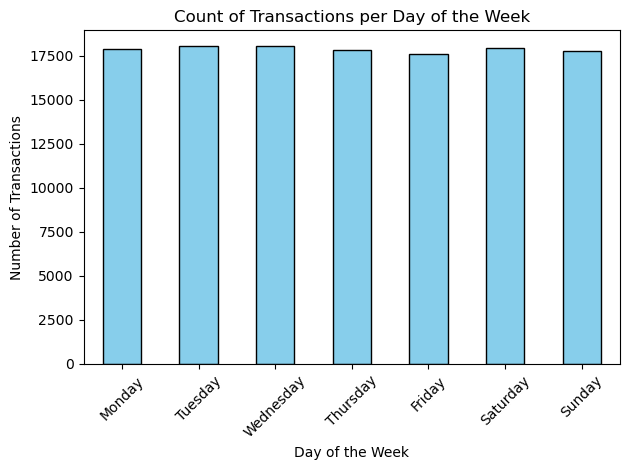

In [347]:
#2. Create the bar plot that shows the count of transactions per day of the week.

transaction_counts = txn_pd.groupby('day_name').size().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# Create a bar plot for the transaction counts
# plt.figure(figsize=(10, 6))
transaction_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Transactions per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()  

# Show the plot
plt.show()

In [348]:
# Group by 'customer_id', 'year', and 'day_name', then count the transactions
txn_grouped = txn_pd.groupby(['customer_id', 'YEAR', 'day_name']).size()

# Convert the series to a DataFrame and reset the index
txn_grouped = txn_grouped.reset_index(name='count')

# Pivot the DataFrame to get 'customer_id' and 'year' on the index, days of the week on the columns
pivoted_data = txn_grouped.pivot_table(index=['customer_id'],columns=['YEAR','day_name'], values='count',aggfunc='sum',fill_value=0)

# Flatten the MultiIndex created by pivot_table
pivoted_data.columns = [col for col in pivoted_data.columns]
pivoted_data.reset_index(inplace=True)


def rename_columns(df):
    # Flatten the MultiIndex columns
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    
    # Rename the columns using the new format
    df.columns = ['customer_id']+ [f'cnt_{col}' for col in df.columns[1:]]
    return df

# Apply the function to the DataFrame

pivoted_data = rename_columns(
pivoted_data)

pivoted_data.head()

,customer_id,cnt_2011_Friday,cnt_2011_Monday,cnt_2011_Saturday,cnt_2011_Sunday,cnt_2011_Thursday,cnt_2011_Tuesday,cnt_2011_Wednesday,cnt_2012_Friday,cnt_2012_Monday,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,CS1112,1,0,0,1,0,0,1,0,0,...,1,1,1,0,0,0,0,0,0,1
1,CS1113,1,1,0,1,0,0,0,2,1,...,0,3,0,0,2,0,0,0,0,1
2,CS1114,0,1,0,1,1,0,2,0,0,...,0,1,1,0,0,0,0,1,0,0
3,CS1115,0,0,1,1,0,0,1,1,1,...,2,0,2,0,0,0,0,1,0,0
4,CS1116,1,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [349]:
# pivoted_data.to_excel('dbfs:/FileStore/tables/annual_day_of_week_counts_pivot.xlsx', index=False)
pivoted_data.to_csv('annual_day_of_week_counts_pivot.csv',index=False)


In [350]:
#generate the features that capture the count of transactions per client, month-end-date and day of the week. In contrast with the annual pivot table in the previous step, here you want to create the pivot with [’customer id’, ’ME DT’] as index to obtain the following output dataframe.

# Create a groupby object with 'customer_id', 'ME_DT', and 'day_name', then count the transactions
txn_grouped = txn_pd.groupby(['customer_id', 'ME_DT', 'day_name']).size()

# Convert the series to a DataFrame and reset the index
txn_grouped = txn_grouped.reset_index(name='count')

# Pivot the DataFrame to get 'customer_id' and 'ME_DT' on the index, days of the week on the columns
pivoted_data = txn_grouped.pivot_table(index=['customer_id', 'ME_DT'],columns='day_name',
values='count',aggfunc='sum', fill_value=0)

# Flatten the MultiIndex created by pivot_table
pivoted_data.columns = [f'cnt_{col}' for col in pivoted_data.columns]
pivoted_data.reset_index(inplace=True)

pivoted_data.isna().sum()

pivoted_data.head()


,customer_id,ME_DT,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday
0,CS1112,2011-06-30,0,0,0,0,0,0,1
1,CS1112,2011-08-31,1,0,0,0,0,0,0
2,CS1112,2011-10-31,0,0,0,1,0,0,0
3,CS1112,2012-04-30,0,0,0,1,0,0,0
4,CS1112,2012-06-30,0,0,0,1,0,0,0


In [351]:
base_table_pd

,CLNT_NO,ME_DT
0,CS1112,2011-05-31
1,CS1112,2011-06-30
2,CS1112,2011-07-31
3,CS1112,2011-08-31
4,CS1112,2011-09-30
...,...,...
323778,CS9000,2014-11-30
323779,CS9000,2014-12-31
323780,CS9000,2015-01-31
323781,CS9000,2015-02-28


In [352]:
# # Join with base_table_pd in section 1.5 and impute 0 for NaN. Save the final output as mth day counts.xlxs.
# mth_day_counts = pivoted_data.join(base_table_pd)

# mth_day_counts.fillna(0)
# mth_day_counts

# pivoted_data.to_excel('dbfs:/FileStore/tables/mth_day_counts.xlxs', index=False)
pivoted_data.to_csv('mth_day_counts.csv',index=False)


#1.7 Date-related features: days since last transaction
In this date-related features set, we will capture the frequency of the transactions in terms of the days since the last transaction. This set of features applies only to the monthly features.

In [353]:
txn_pd

,customer_id,tran_amount,txn_date,ME_DT,YEAR,day_of_week,day_name
0,CS5295,35,2013-02-11,2013-02-28,2013,0,Monday
1,CS4768,39,2015-03-15,2015-03-31,2015,6,Sunday
2,CS2122,52,2013-02-26,2013-02-28,2013,1,Tuesday
3,CS1217,99,2011-11-16,2011-11-30,2011,2,Wednesday
4,CS1850,78,2013-11-20,2013-11-30,2013,2,Wednesday
...,...,...,...,...,...,...,...
124995,CS8433,64,2011-06-26,2011-06-30,2011,6,Sunday
124996,CS7232,38,2014-08-19,2014-08-31,2014,1,Tuesday
124997,CS8731,42,2014-11-28,2014-11-30,2014,4,Friday
124998,CS8133,13,2013-12-14,2013-12-31,2013,5,Saturday


In [354]:
#1 
last_monthly_purchase = txn_pd.groupby(['customer_id', 'ME_DT'])['txn_date'].max().reset_index()

last_monthly_purchase.rename(columns={'txn_date': 'last_monthly_purchase', 'customer_id': 'CLNT_NO'}, inplace=True)

last_monthly_purchase


,CLNT_NO,ME_DT,last_monthly_purchase
0,CS1112,2011-06-30,2011-06-15
1,CS1112,2011-08-31,2011-08-19
2,CS1112,2011-10-31,2011-10-02
3,CS1112,2012-04-30,2012-04-08
4,CS1112,2012-06-30,2012-06-24
...,...,...,...
103229,CS9000,2014-01-31,2014-01-12
103230,CS9000,2014-05-31,2014-05-08
103231,CS9000,2014-07-31,2014-07-08
103232,CS9000,2014-08-31,2014-08-24


In [355]:
#2 Join base table pd with last monthly purchase as you did in section 1.5. 
last_monthly_purchase_base = base_table_pd.merge(last_monthly_purchase, on=['CLNT_NO', 'ME_DT'], how='left')

last_monthly_purchase_base


,CLNT_NO,ME_DT,last_monthly_purchase
0,CS1112,2011-05-31,NaT
1,CS1112,2011-06-30,2011-06-15
2,CS1112,2011-07-31,NaT
3,CS1112,2011-08-31,2011-08-19
4,CS1112,2011-09-30,NaT
...,...,...,...
323778,CS9000,2014-11-30,NaT
323779,CS9000,2014-12-31,NaT
323780,CS9000,2015-01-31,NaT
323781,CS9000,2015-02-28,2015-02-28


In [356]:
#3 To impute NaT: in July the value for the last monthly purchase is the previous line value: 2011-06-15. In other words, for every client we want to forward-fill the NaT values.

last_monthly_purchase_base = last_monthly_purchase_base.groupby('CLNT_NO').apply(lambda x: x.ffill())

last_monthly_purchase_base[92:98]

/var/folders/g5/p7y5bcps6rlf2dp0h1gcfcqc0000gp/T/ipykernel_88848/2039137212.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  last_monthly_purchase_base = last_monthly_purchase_base.groupby('CLNT_NO').apply(lambda x: x.ffill())


,CLNT_NO,ME_DT,last_monthly_purchase
92,CS1113,2015-02-28,2015-02-09
93,CS1113,2015-03-31,2015-02-09
94,CS1114,2011-05-31,NaT
95,CS1114,2011-06-30,NaT
96,CS1114,2011-07-31,2011-07-14
97,CS1114,2011-08-31,2011-08-24


In [357]:
last_monthly_purchase_base

,CLNT_NO,ME_DT,last_monthly_purchase
0,CS1112,2011-05-31,NaT
1,CS1112,2011-06-30,2011-06-15
2,CS1112,2011-07-31,2011-06-15
3,CS1112,2011-08-31,2011-08-19
4,CS1112,2011-09-30,2011-08-19
...,...,...,...
323778,CS9000,2014-11-30,2014-08-24
323779,CS9000,2014-12-31,2014-08-24
323780,CS9000,2015-01-31,2014-08-24
323781,CS9000,2015-02-28,2015-02-28


In [358]:
#4 Subtract the two date columns and convert the output to .dt.days to calculate the column ’days since last txn’

last_monthly_purchase_base['days_since_last_txn'] = (
    last_monthly_purchase_base['ME_DT'] - last_monthly_purchase_base['last_monthly_purchase']
).dt.days

last_monthly_purchase_base

,CLNT_NO,ME_DT,last_monthly_purchase,days_since_last_txn
0,CS1112,2011-05-31,NaT,NaN
1,CS1112,2011-06-30,2011-06-15,15.0
2,CS1112,2011-07-31,2011-06-15,46.0
3,CS1112,2011-08-31,2011-08-19,12.0
4,CS1112,2011-09-30,2011-08-19,42.0
...,...,...,...,...
323778,CS9000,2014-11-30,2014-08-24,98.0
323779,CS9000,2014-12-31,2014-08-24,129.0
323780,CS9000,2015-01-31,2014-08-24,160.0
323781,CS9000,2015-02-28,2015-02-28,0.0


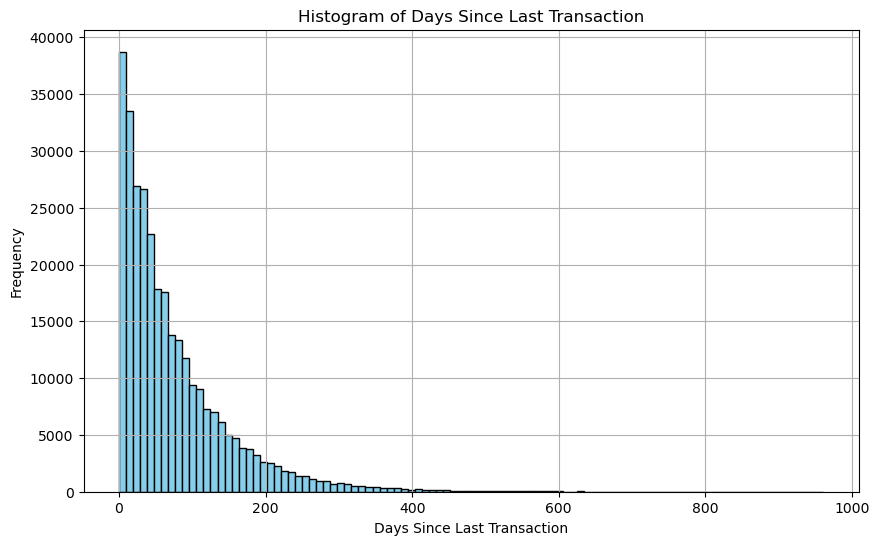

In [359]:
#5 Plot a histogram of the ’days since last txn’. Based on the values you observe in the histogram, impute the remaining NaN values (i.e. for the initial months before a client makes a purchase). Save the columns [’CLNT NO’, ’ME DT’, ’days since last txn’] as days since last txn.xlsx.

# Drop rows where 'days_since_last_txn' is NaN for the histogram
days_since_last_txn_nonan = last_monthly_purchase_base.dropna(subset=['days_since_last_txn'])

plt.figure(figsize=(10, 6))
plt.hist(days_since_last_txn_nonan['days_since_last_txn'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Days Since Last Transaction')
plt.xlabel('Days Since Last Transaction')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



The histogram indicates a right-skewed distribution, we'll use the median of day_since_last_txn to impute NaN

In [360]:
# Impute the NaN values with median
last_monthly_purchase_base['days_since_last_txn'].fillna(days_since_last_txn_nonan['days_since_last_txn'].median(), inplace=True)

# Now save the required columns to an Excel file
output_df = last_monthly_purchase_base[['CLNT_NO', 'ME_DT', 'days_since_last_txn']]

output_df

#save to excel 
# output_df.to_excel('dbfs:/FileStore/tables/days_since_last_txn.xlsx', index=False)
output_df.to_csv('days_since_last_txn.csv', index=False)